In [1]:
%pylab inline
from sklearn import linear_model
import cv2
from math import exp
from matplotlib import pyplot as plt
from skimage import measure
from astropy.io import fits
import pickle
from PIL import Image
from scipy.stats import norm
from astropy.convolution import convolve, convolve_fft

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]
   
    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]
    
    return array(kernel2d)

def get_correct_PSF_representation(PSF, image):
    size_e = len(image) - len(PSF)
    PSF_e = np.pad(PSF, ((size_e/2,0),(size_e/2,0)), mode='constant')
    PSF_e = np.pad(PSF_e, ((0,size_e/2),(0,size_e/2)), mode='constant')
    PSF_e = fft.fftshift(PSF_e)
    return PSF_e

In [3]:
# Auxiliary functions to calculate beta
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

def get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N):
    max_iter_beta = 10000 # maximum number of iterations for the fit
    beta_epsilon = 0.001 # minimum distance for convergence of the fit
    epsilon = 0.001 # avoids division by zero
    beta = 1
    gamma_prime = 0

    beta_converges = False
    num_iter = 0

    while not beta_converges and num_iter < max_iter_beta:
        num_iter = num_iter + 1
        denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
        fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
        fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
        D_n = ifft2(fourier_D_n)
        D_r = ifft2(fourier_D_r)
    
        # Here, they select pixels which are one (really three) sigma above the image noise
        # We don't do that
    
        prev_beta = beta
    
        # The fit we are using ignores imaginary parts, so we fit the squares instead 
        beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
        if abs(beta - prev_beta) < beta_epsilon:
            beta_converges = True
    return beta

In [4]:
# Auxiliary functions to calculate S
""""
def get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
    fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
    fourier_S = fourier_S/denom
    S = ifft2(fourier_S)
    return real(S)
"""

'"\ndef get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N):\n    epsilon = 0.001 # avoids division by zero\n    fourier_R = fft.fft2(R)\n    fourier_N = fft.fft2(N)\n    fourier_PSF_r = fft.fft2(PSF_r)\n    fourier_PSF_n = fft.fft2(PSF_n)\n    F_r = 1\n    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)\n    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    \n    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon\n    fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N\n    fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R\n    fourier_S = fourier_S/denom\n    S = ifft2(fourier_S)\n    return real(S)\n'

In [5]:
# Auxiliary functions to calculate S corr
def get_S_n(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom_n =(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)
    denom_n = denom_n + (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2) + epsilon
    fourier_S_n = ((F_n)*(conjugate(fourier_PSF_n))/(sigma_n**2)) 
    fourier_S_n = fourier_S_n * (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2)
    fourier_k_n = fourier_S_n/denom_n
    fourier_S_n = fourier_k_n * fourier_N
    S_n = ifft2(fourier_S_n)
    k_n = ifft2(fourier_k_n)
    return real(S_n), real(k_n)

def get_S_r(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom_r =(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)
    denom_r = denom_r + (F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r))/(sigma_r**2) + epsilon
    fourier_S_r = ((F_n)*(fourier_PSF_n*conjugate(fourier_PSF_n))/(sigma_n**2)) 
    fourier_S_r = fourier_S_r * (F_r**2)*(conjugate(fourier_PSF_r))/(sigma_r**2)
    fourier_k_r = fourier_S_r/denom_r
    fourier_S_r = fourier_k_r * fourier_R
    S_r = ifft2(fourier_S_r)
    k_r = ifft2(fourier_k_r)
    return real(S_r), real(k_r)

def get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    S_n, k_n = get_S_n(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    S_r, k_r = get_S_r(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    S = S_n - S_r
    return S, k_n, k_r

def get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r):
    S, k_n, k_r = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
    V_e_n = N_b + r_n**2
    V_e_r = R_b + r_r**2
    V_S_n = convolve(V_e_n, k_n**2, boundary='extend')
    V_S_r = convolve(V_e_r, k_r**2, boundary='extend')
    S_corr = S/np.sqrt(V_S_n + V_S_r)
    return real(S_corr)

In [6]:
# Auxiliary functions to calculate D
def get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N):
    epsilon = 0.001 # avoids division by zero
    fourier_R = fft.fft2(R)
    fourier_N = fft.fft2(N)
    fourier_PSF_r = fft.fft2(PSF_r)
    fourier_PSF_n = fft.fft2(PSF_n)
    F_r = 1
    F_n = get_beta(sigma_r, sigma_n, fourier_PSF_r, fourier_PSF_n, fourier_R, fourier_N)
    denom =(sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n))    
    denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    denom = sqrt(denom)
    fourier_D = (F_r)*fourier_PSF_r*fourier_N
    fourier_D = fourier_D - (F_n)*fourier_PSF_n*fourier_R
    fourier_D = fourier_D/denom
    D = ifft2(fourier_D)
    return real(D)

In [7]:
# Auxiliary functions to print candidates
def print_candidates(S, num_sigma):
    sigma_S = std(S)
    candidates = amin(S)*zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) < num_sigma*sigma_S:
                candidates[i][j] = 255
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates = measure.label(candidates)
    for i in range(np.max(candidates)):
        x = str(average(np.where(candidates == (i + 1))[0]))
        y = str(average(np.where(candidates == (i + 1))[1]))
        print("Candidate " + str(i + 1) + ": (" + x + ", " + y + ")")

In [8]:
# Auxiliary functions to print candidates
def print_candidates_min(S, num_sigma):
    sigma_S = std(S)
    candidates_min = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) < ( num_sigma*sigma_S):
                candidates_min[i][j] = 255
    candidates_min  = np.abs(candidates_min - 255)
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates_min, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates_min = measure.label(candidates_min)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_min)):
        y = str(average(np.where(candidates_min == (i + 1))[0]))
        x = str(average(np.where(candidates_min == (i + 1))[1]))
        #cross on the candidate

        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (minimum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")
# Auxiliary functions to print candidates
def print_candidates_max(S, num_sigma):
    sigma_S = std(S)
    candidates_max = np.zeros(shape(S))
    for i in range(len(S)):
        for j in range(len(S)):
            if abs(S[i][j]) > ( num_sigma*sigma_S):
                candidates_max[i][j] = 255
    fig = plt.figure(figsize = (8,8))
    plt.imshow(candidates_max, cmap = 'Greys_r', origin='lower')
    plt.title('Transient Candidates', fontsize=18)
    plt.xlabel("x (pixels) ", fontsize=20)
    plt.ylabel("y (pixels) ", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    candidates_max = measure.label(candidates_max)
    #For the cross on the candidates
    x_max, y_max = shape(S)
    #--------------------------
    for i in range(np.max(candidates_max)):
        y = str(average(np.where(candidates_max == (i + 1))[0]))
        x = str(average(np.where(candidates_max == (i + 1))[1]))
        #cross on the candidate
        axhline(float(y),(float(x)-x_max*0.02)/x_max,(float(x)+x_max*0.02)/x_max,c='c')
        axvline(float(x),(float(y)-y_max*0.02)/y_max,(float(y)+y_max*0.02)/y_max,c='c') 
        text(float(x)+x_max*0.02,float(y)+y_max*0.02,str(i + 1),color='c',fontsize=12)
        #--------------------------
        print("Candidate (maximum analysis) " + str(i + 1) + ": (" + x + ", " + y + ")")

Tests with simulated images

In [9]:
R = cv2.imread('./Images/withGaussianSources/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/withGaussianSources/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 

#This is wrong.
#For testing
R_b = R
N_b = N

r_n = 0
r_r = 0

#Previous parameters
sigma_r = 50 
sigma_n = 50 

tile_size = 25
sigma_PSF = 3.
PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), N)


S_corr = get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)


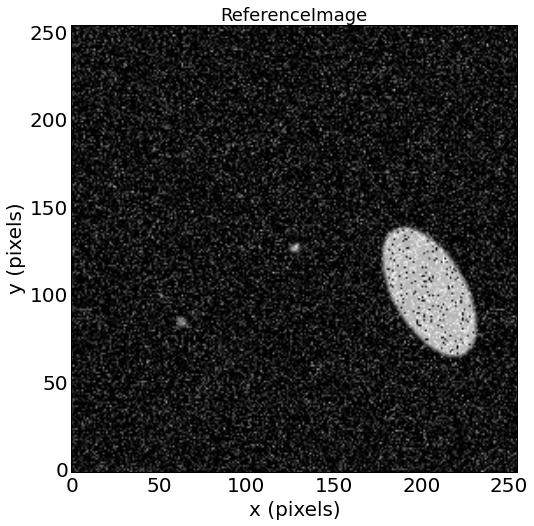

In [10]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [11]:
plt.close(fig)

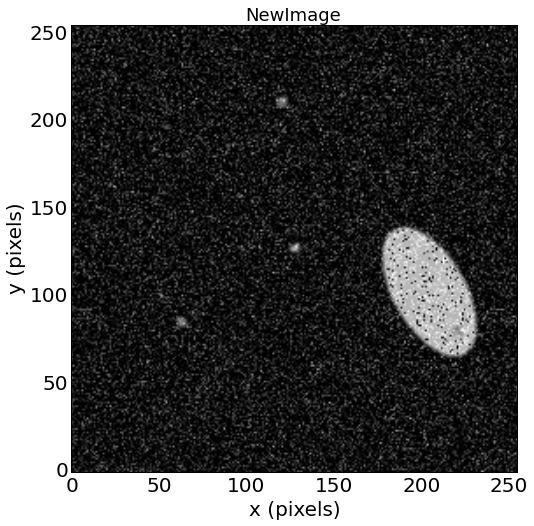

In [12]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [13]:
plt.close(fig)

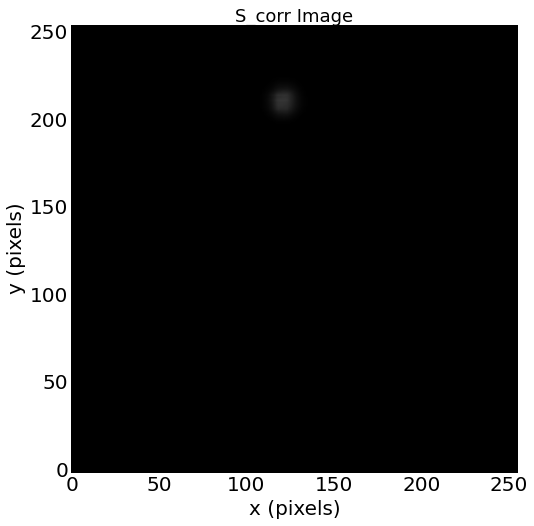

In [14]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(S_corr), cmap = 'gray', origin='lower')
plt.title('S_corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [15]:
plt.close(fig)

Candidate 1: (126.741323311, 126.868179287)


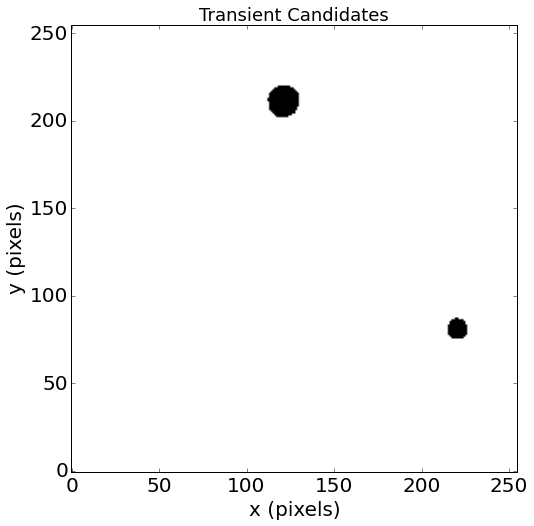

In [16]:
print_candidates(S_corr, 5)

In [17]:
plt.close(fig)

Candidate (minimum analysis) 1: (219.990825688, 81.0550458716)
Candidate (minimum analysis) 2: (120.796153846, 210.588461538)


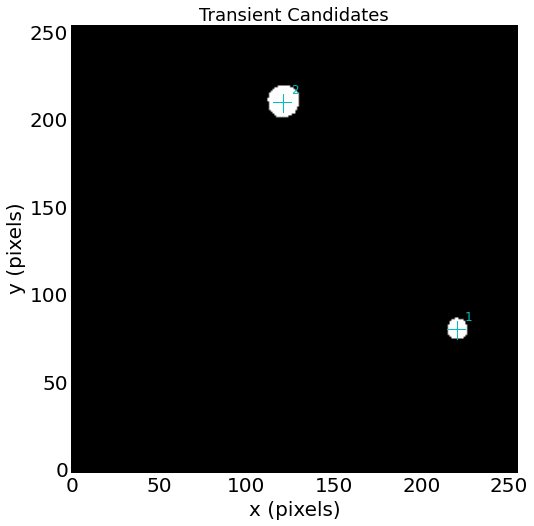

In [18]:
print_candidates_min(S_corr,5)

In [19]:
plt.close(fig)

Candidate (maximum analysis) 1: (219.888888889, 80.8888888889)
Candidate (maximum analysis) 2: (120.79144385, 210.572192513)


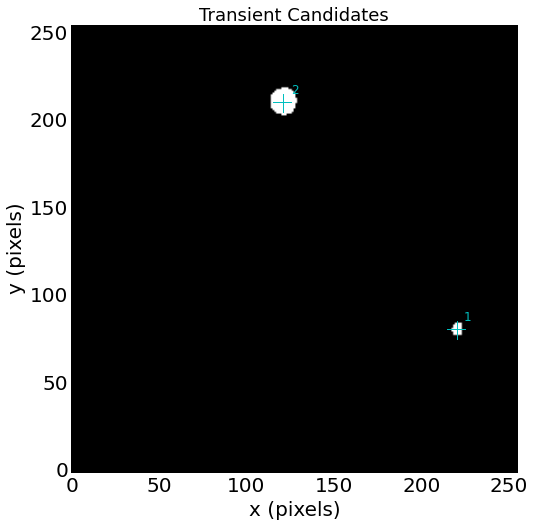

In [20]:
print_candidates_max(S_corr,8)

In [21]:
plt.close(fig)

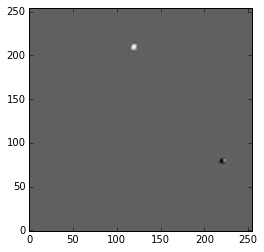

In [22]:
plt.imshow(D, origin = "lower", cmap="Greys_r")

In [23]:
plt.close(fig)

In [24]:
R = cv2.imread('./Images/withNoise/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/withNoise/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 

#This is wrong.
#For testing
R_b = R
N_b = N

r_n = 0
r_r = 0

#Previous parameters
sigma_r = 50 + 51.768716422179139 + 52.48809388804284
sigma_n = 50 + 51.768716422179139 + 52.48809388804284

tile_size = 25
sigma_PSF = 3.
PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF), N)


S_corr = get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)


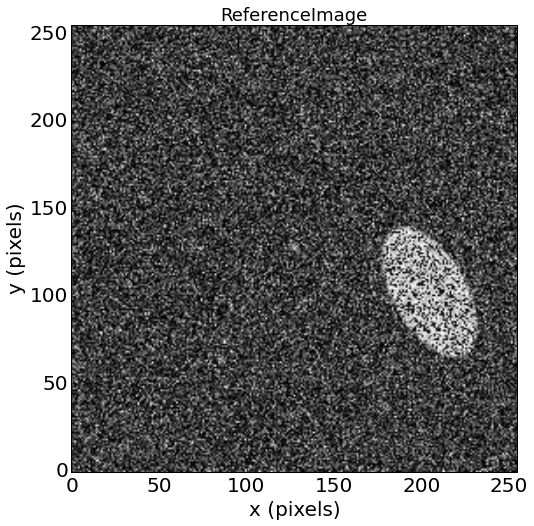

In [25]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('ReferenceImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [26]:
plt.close(fig)

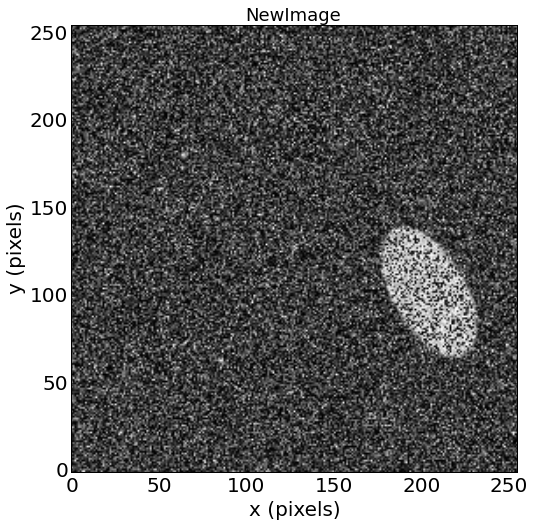

In [27]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('NewImage', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [28]:
plt.close(fig)

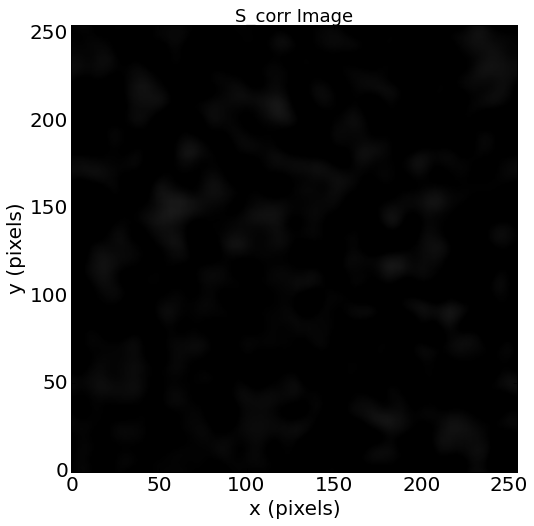

In [29]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(S_corr), cmap = 'gray', origin='lower')
plt.title('S_corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [30]:
plt.close(fig)

Candidate 1: (123.789333214, 123.200305022)
Candidate 2: (3.68965517241, 252.931034483)
Candidate 3: (248.010695187, 248.064171123)


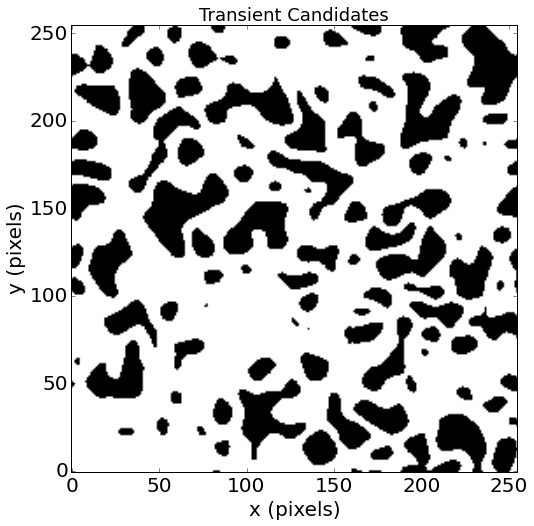

In [42]:
print_candidates(S_corr, 1)

In [32]:
plt.close(fig)

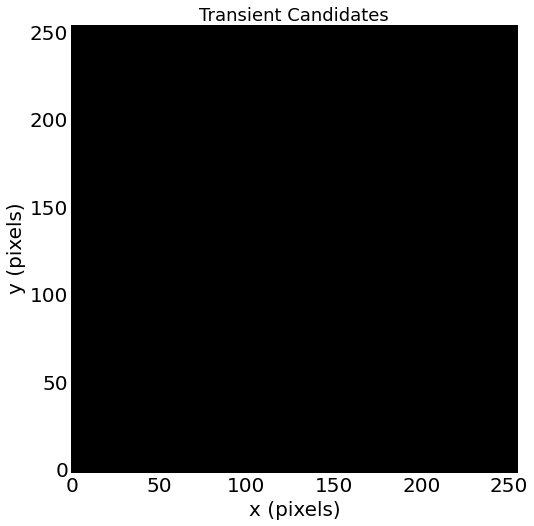

In [33]:
print_candidates_min(S_corr,5)

In [34]:
plt.close(fig)

Candidate (maximum analysis) 1: (5.79820627803, 14.5515695067)
Candidate (maximum analysis) 2: (17.9126213592, 6.53398058252)
Candidate (maximum analysis) 3: (38.7333333333, 0.466666666667)
Candidate (maximum analysis) 4: (92.0208105148, 32.7557502738)
Candidate (maximum analysis) 5: (82.0263157895, 1.42105263158)
Candidate (maximum analysis) 6: (126.419354839, 0.709677419355)
Candidate (maximum analysis) 7: (170.383801705, 67.3454373224)
Candidate (maximum analysis) 8: (201.73800738, 8.84870848708)
Candidate (maximum analysis) 9: (221.353899884, 19.8463329453)
Candidate (maximum analysis) 10: (246.864951768, 10.1446945338)
Candidate (maximum analysis) 11: (30.4838709677, 5.64516129032)
Candidate (maximum analysis) 12: (178.132926829, 27.3829268293)
Candidate (maximum analysis) 13: (51.2576271186, 22.0101694915)
Candidate (maximum analysis) 14: (0.0, 14.0)
Candidate (maximum analysis) 15: (31.8571428571, 22.3076923077)
Candidate (maximum analysis) 16: (250.461538462, 28.4102564103)
Can

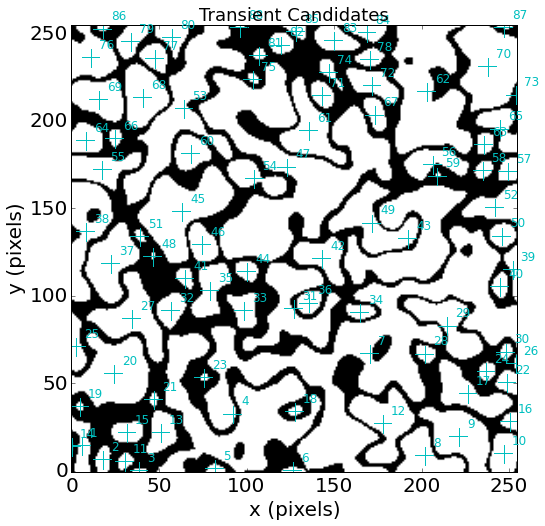

In [35]:
print_candidates_max(S_corr,0.4)

In [36]:
plt.close(fig)

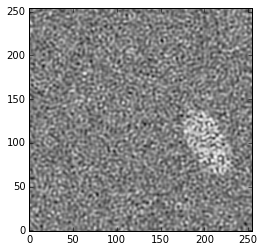

In [37]:
plt.imshow(D, origin = "lower", cmap="Greys_r")

In [ ]:
plt.close(fig)

Tests with real images and point transients

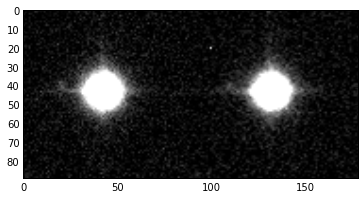

In [24]:
R = fits.getdata('./Fits/science.fits')
N = fits.getdata('./Fits/template_points.fits')
vis = np.concatenate((R, N), axis=1)
plt.imshow(Image.fromarray(vis), cmap = 'gray')

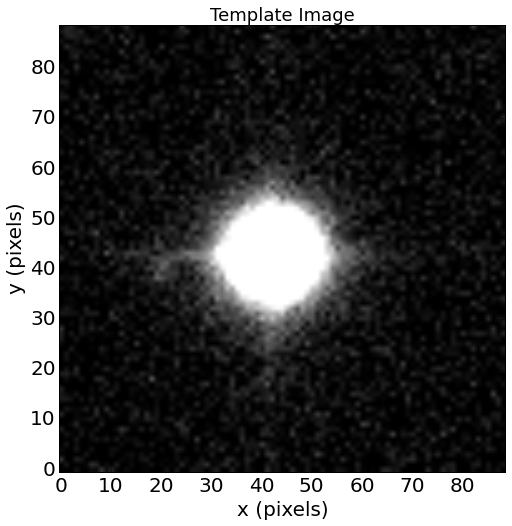

In [25]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('Template Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [26]:
plt.close(fig)

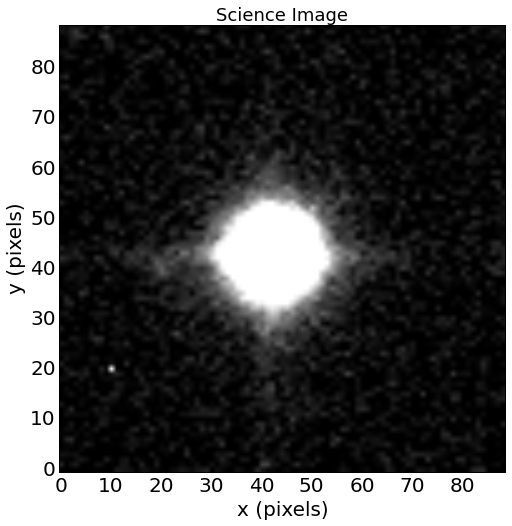

In [27]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('Science Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [28]:
plt.close(fig)

In [29]:
# The mask has 0s for the background and 1s for the source
mask = asarray(pickle.load(open("./Fits/mask.p", "rb" )))

In [30]:
# Estimating noise parameters
R_background_pixels = []
N_background_pixels = []
for i in range(len(mask)):
    for j in range(len(mask)):
        # We exclude the new source in the background
        if mask[i, j] == 0 and (i != 20 or j != 10):
            R_background_pixels.append(R[i, j])
            N_background_pixels.append(N[i, j])
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 19.9943
sigma_n: 17.737


In [31]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
# Because the PSFs have such large sigmas, the tile size greatly affects sensitivity
tile_size = 3

PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 1738.95
sigma_PSF_n: 1879.76


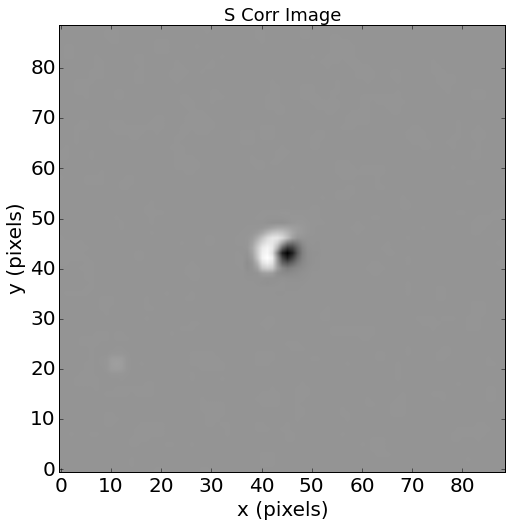

In [32]:
# Calculating S
# This has to be remade
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S_corr = get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'Greys_r', origin='lower')
plt.title('S Corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [37]:
plt.close(fig)

Candidate 1: (44.0093171666, 44.0145500957)
Candidate 2: (41.5, 43.0)


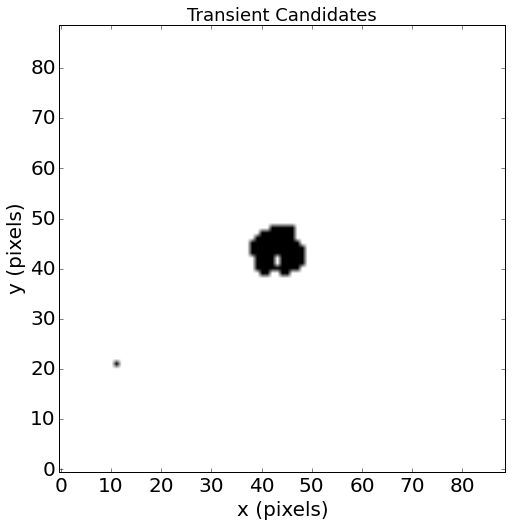

In [38]:
# We pick the highest threshold (up to two decimal places) with which both transients are detected.
print_candidates(S_corr, 1.3)

In [39]:
plt.close(fig)

Candidate (minimum analysis) 1: (11.0, 21.0)
Candidate (minimum analysis) 2: (43.0740740741, 43.5679012346)


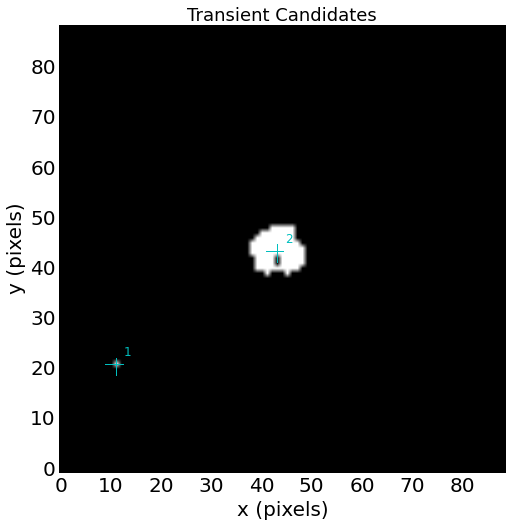

In [45]:
print_candidates_min(S_corr, 1.4)

In [41]:
plt.close(fig)

Candidate (maximum analysis) 1: (11.0, 21.0)
Candidate (maximum analysis) 2: (43.0481927711, 43.4578313253)


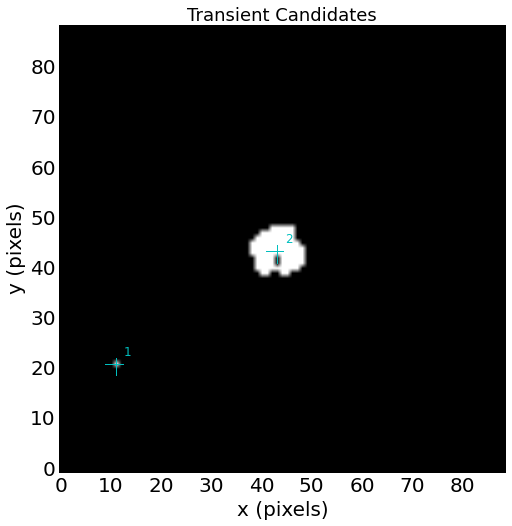

In [42]:
print_candidates_max(S_corr, 1.3)

In [35]:
plt.close(fig)

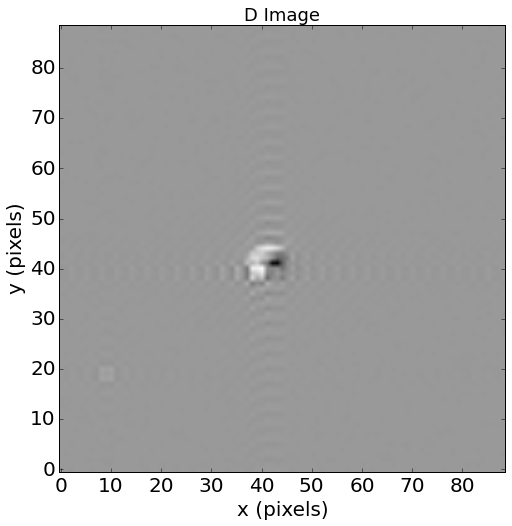

In [46]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [47]:
plt.close(fig)

Tests with real images and gaussian transients

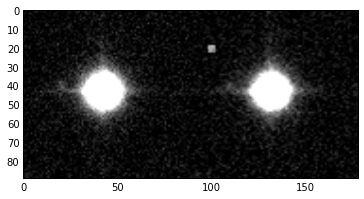

In [48]:
R = fits.getdata('./Fits/science.fits')
N = fits.getdata('./Fits/template_gaussians.fits')
vis = np.concatenate((R, N), axis=1)
plt.imshow(Image.fromarray(vis), cmap = 'gray')
mask = asarray(pickle.load(open("./Fits/mask.p", "rb" )))

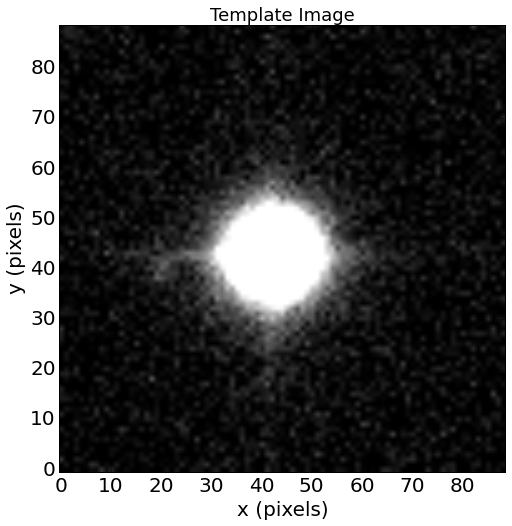

In [49]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(R), cmap = 'gray', origin='lower')
plt.title('Template Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [50]:
plt.close(fig)

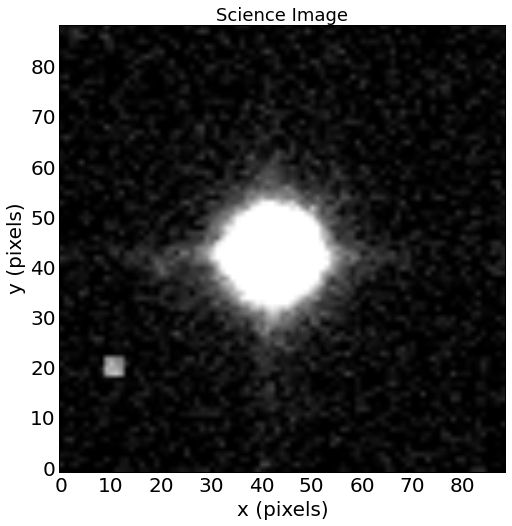

In [51]:
fig = plt.figure(figsize = (8,8))
plt.imshow(Image.fromarray(N), cmap = 'gray', origin='lower')
plt.title('Science Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [52]:
plt.close(fig)

In [53]:
# Estimating noise parameters
R_background_pixels = []
N_background_pixels = []
for i in range(len(mask)):
    for j in range(len(mask)):
        # We exclude the new source in the background
        if mask[i, j] == 0 and ((i < 19 or i > 21) or (j < 9 or j > 11)):
            R_background_pixels.append(R[i, j])
            N_background_pixels.append(N[i, j])
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 19.9963
sigma_n: 18.3795


In [54]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
# Because the PSFs have such large sigmas, the tile size greatly affects sensitivity
tile_size = 3

PSF_r = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix((tile_size - 1)/2, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 1738.95
sigma_PSF_n: 1848.02


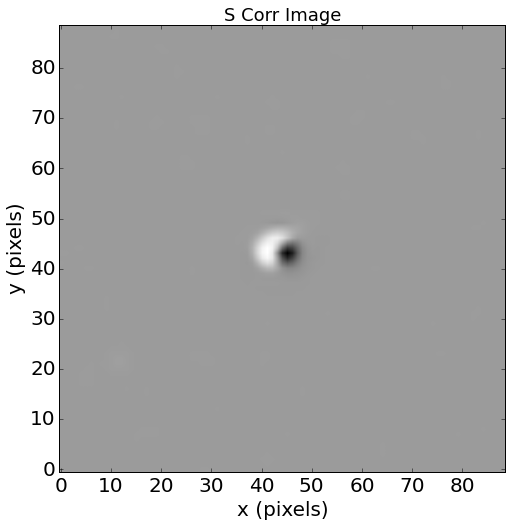

In [55]:
# Calculating S
# This has to be remade
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S_corr = get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'Greys_r', origin='lower')
plt.title('S Corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [56]:
plt.close(fig)

Candidate 1: (44.0130618517, 44.0139582533)


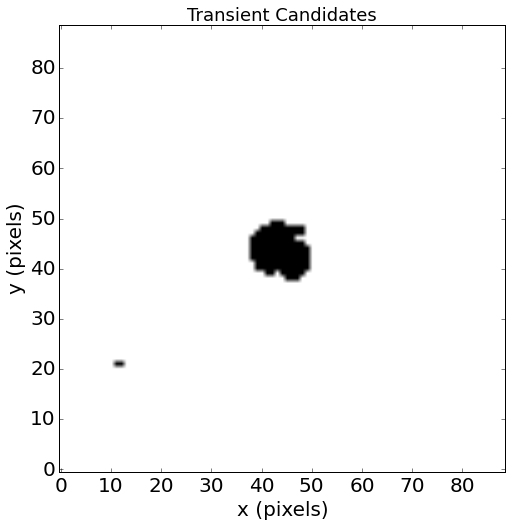

In [57]:
# We pick the highest threshold (up to two decimal places) with which both transients are detected.
print_candidates(S_corr, 0.51)

In [58]:
plt.close(fig)

Candidate (minimum analysis) 1: (11.5, 21.0)
Candidate (minimum analysis) 2: (43.6, 43.4909090909)


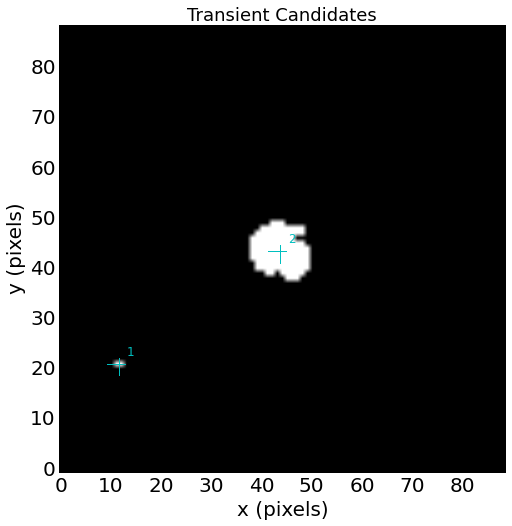

In [59]:
print_candidates_min(S_corr, 0.51)

In [60]:
plt.close(fig)

Candidate (maximum analysis) 1: (11.5, 21.5)
Candidate (maximum analysis) 2: (43.6, 43.4909090909)


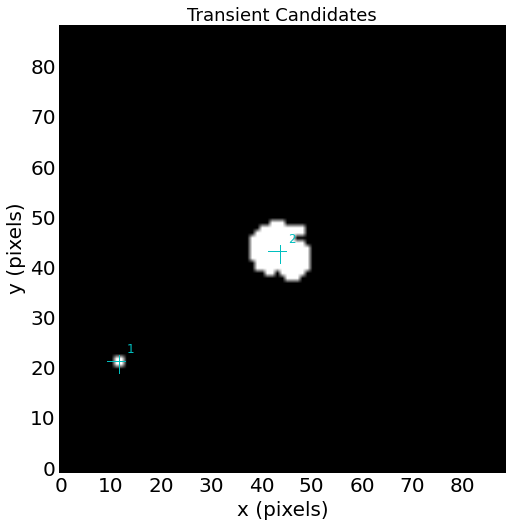

In [65]:
print_candidates_max(S_corr, 0.50)

In [66]:
plt.close(fig)

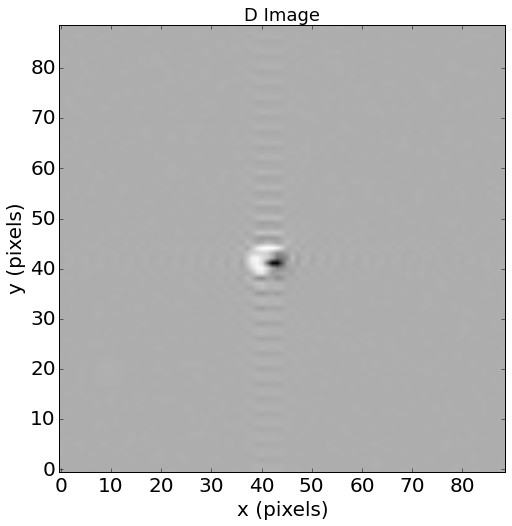

In [67]:
# Calculating D
D = get_D(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [68]:
plt.close(fig)

Tests with real images and transients

In [69]:
R = fits.getdata('./Fits/Real/S-1/33,15.fits')
N = fits.getdata('./Fits/Real/S+0/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [70]:
# Estimating noise parameters
# Because we have no mask to differentiate background and sources in this case, we take noise 
# as the 10% least intense pixels of the images
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(N))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 3.43099
sigma_n: 4.04183


In [71]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 7.02189
sigma_PSF_n: 10.1536


In [ ]:
# Calculating S
# This has to be remade
r_n = sigma_n
r_r = sigma_r

N_b = N
R_b = R

S_corr = get_S_corr(sigma_r, sigma_n, PSF_r, PSF_n, R, N, N_b, R_b, r_n, r_r)

fig = plt.figure(figsize = (8,8))
plt.imshow(S_corr, cmap = 'Greys_r', origin='lower')
plt.title('S Corr Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [40]:
plt.close(fig)

Candidate 1: (599.052484054, 598.889898444)


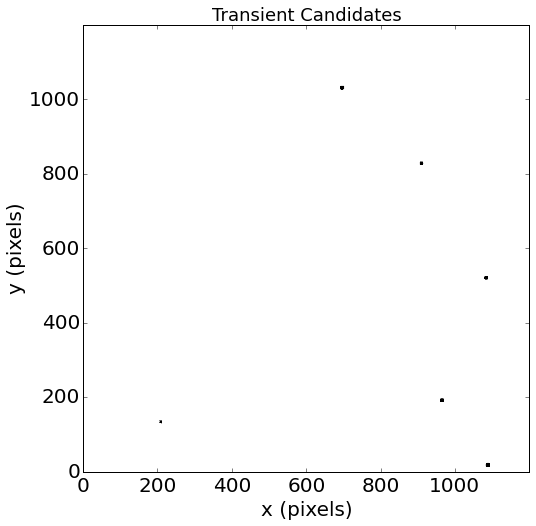

In [41]:
print_candidates(S, 30)

In [42]:
plt.close(fig)

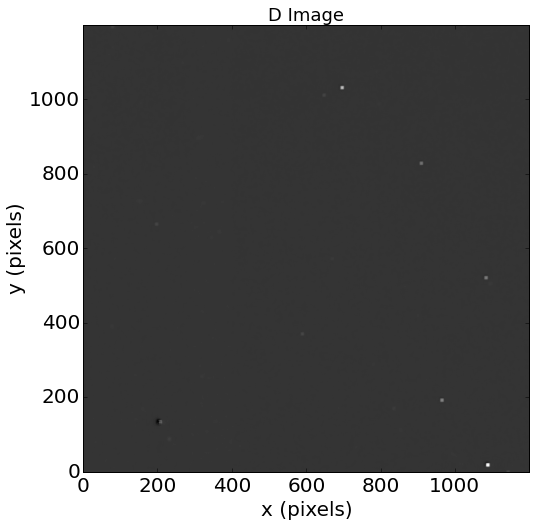

In [43]:
# Calculating D
D = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [44]:
plt.close(fig)

For other real images

In [45]:
R = fits.getdata('./Fits/Real/S+0/33,15.fits')
N = fits.getdata('./Fits/Real/S+1/33,15.fits')
# This pipeline requires the dimensions of the images to be odd.
R = R[:-1,:-1]
N = N[:-1,:-1]

In [46]:
# Estimating noise parameters
R_background_pixels = sort(R)[0:int(0.1*len(R))]
N_background_pixels = sort(N)[0:int(0.1*len(R))]
sigma_r = std(R_background_pixels) 
sigma_n = std(N_background_pixels)

(mu_r, sigma_r) = norm.fit(R_background_pixels)
(mu_n, sigma_n) = norm.fit(N_background_pixels)
print("sigma_r: " + str(sigma_r))
print("sigma_n: " + str(sigma_n))

sigma_r: 4.04183
sigma_n: 3.47929


In [47]:
# Estimating PSFs.
(mu_PSF_r, sigma_PSF_r) = norm.fit(np.concatenate([-1*R.ravel(), R.ravel()]))
(mu_PSF_n, sigma_PSF_n) = norm.fit(np.concatenate([-1*N.ravel(), N.ravel()]))
tile_size = 5

PSF_r = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_r), R)
PSF_n = get_correct_PSF_representation(get_convolution_matrix(tile_size - 1, sigma_PSF_n), N)
print("sigma_PSF_r: " + str(sigma_PSF_r))
print("sigma_PSF_n: " + str(sigma_PSF_n))

sigma_PSF_r: 10.1536
sigma_PSF_n: 16.2016


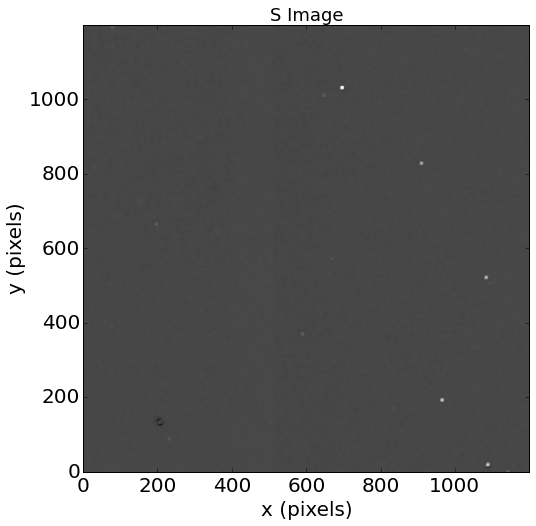

In [48]:
# Calculating S
S = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(S, cmap = 'Greys_r', origin='lower')
plt.title('S Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [49]:
plt.close(fig)

Candidate 1: (11.5882352941, 1086.29411765)
Candidate 2: (15.0, 1089.0)
Candidate 3: (127.487804878, 207.56097561)
Candidate 4: (138.702970297, 202.544554455)
Candidate 5: (131.25, 208.0)


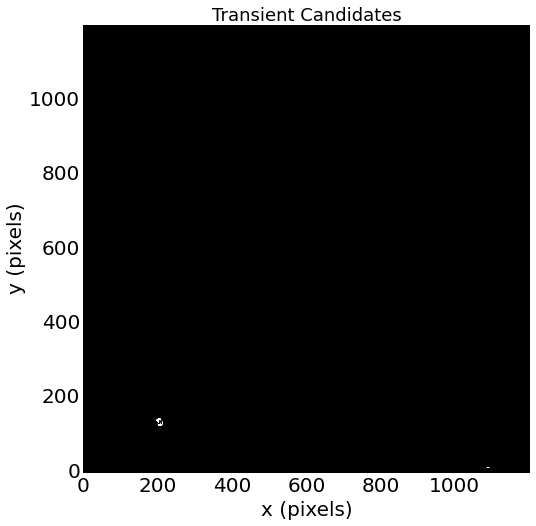

In [50]:
print_candidates(S, 50)

In [51]:
plt.close(fig)

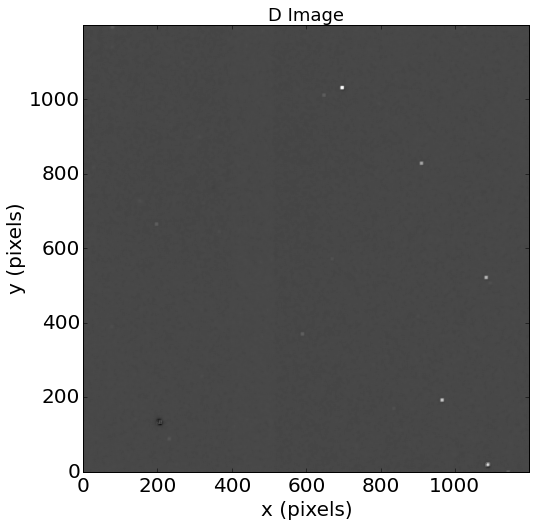

In [52]:
# Calculating D
D = get_S(sigma_r, sigma_n, PSF_r, PSF_n, R, N)
fig = plt.figure(figsize = (8,8))
plt.imshow(D, cmap = 'Greys_r', origin='lower')
plt.title('D Image', fontsize=18)
plt.xlabel("x (pixels) ", fontsize=20)
plt.ylabel("y (pixels) ", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [53]:
plt.close(fig)